# Homework 7: Fake News Classification

Due: 11:59pm, June 2.

## Please restart the kernel and run all before you submit!

## Your Name: Amay Jain

Throughout the HW, function docstrings, incline comments, and markdown are required. 

## Acquiring data

Read the csv file from the given link 

    train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Regular expression operations
import re  
# built in string module: change uppercase and lowercase
import string

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow import keras

# requires update to tensorflow 2.4
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

from nltk.corpus import stopwords

2024-05-30 12:04:18.595573: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"
df = pd.read_csv(train_url)

df.shape

(22449, 4)

In [3]:
df.head()

,Unnamed: 0,title,text,fake
0,17366,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,5634,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,17487,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,12217,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,5535,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0


## Make Datasets

Write a function called `make_dataset`. This function should do four things:

1. Change the text to lowercase.

2. Remove stopwords from the article text and title. A stopword is a word that is usually considered to be uninformative, such as “the,” “and,” or “but.” You may find this StackOverFlow thread to be helpful.

3. Construct and return a tf.data.Dataset with two inputs and one output. The input should be of the form (title, text), and the output should consist only of the fake column. You may find it helpful to consult lecture notes or this tutorial for reference on how to construct and use Datasets with multiple inputs.

Helpful resources:
1. Lower case: https://saturncloud.io/blog/how-to-lowercase-a-pandas-dataframe-string-column-if-it-has-missing-values/

2. Remove stopwords: https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe. You need to install nltk library. If you do not want to install it, you can use Google colab.

3. Tensorflow dataset with multiple inputs and set batch: https://stackoverflow.com/questions/52582275/tf-data-with-multiple-inputs-outputs-in-keras.

In [4]:
def make_dataset(df):

    data = df.copy()

    data['text'] = data['text'].str.lower()

    stop = stopwords.words('english')

    data['title'] = data['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

    data = tf.data.Dataset.from_tensor_slices(
        (
            {
                'title': data[['title']],
                'text': data[['text']]
            },
            {
                'fake': data[['fake']]
            }
        )
    )

    return data

In [5]:
tf_df = make_dataset(df)

2024-05-30 12:04:47.367180: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
for summary, label in tf_df.take(1):

    print('title\n')
    print(summary['title'])
    print('\n\n\n')
    
    print('text\n')
    print(summary['text'])
    print('\n\n\n')

    print('label\n')
    print(label)

# len(tf_df)

title

tf.Tensor([b"Merkel: Strong result Austria's FPO 'big challenge' parties"], shape=(1,), dtype=string)




text

tf.Tensor([b'german chancellor angela merkel said monday strong showing austria anti-immigrant freedom party (fpo) sunday election big challenge parties. speaking news conference berlin, merkel added hoping close cooperation austria conservative election winner sebastian kurz european level.'], shape=(1,), dtype=string)




label

{'fake': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>}


## Train test split:

Write a function `train_test_split` to do train test split for any tensorflow dataset. The passing argument should be the training size.


Then, you should use your function to do train_test split and the training size is 80% of your dataset. 

In [7]:
def train_test_split(data, train_size = 0.8):

    train_size = int(train_size * len(df))

    train, test = data.take(train_size), data.skip(train_size)

    return train, test

In [8]:
train, test = train_test_split(tf_df, 0.8)

## Text vectorization

Here is one option:

    #preparing a text vectorization layer for tf model
    size_vocabulary = 2000

    def standardization(input_data):
        lowercase = tf.strings.lower(input_data)
        no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
        return no_punctuation 

    title_vectorize_layer = TextVectorization(
        standardize=standardization,
        max_tokens=size_vocabulary, # only consider this many words
        output_mode='int',
        output_sequence_length=500) 

    title_vectorize_layer.adapt(train.map(lambda x, y: x["title"]))
    
You can also use your preferred vectorization, e.g. text vectorization. You are also welcome to change the parameters such as `size_vocabulary` and `output_sequence_length`. 



In [9]:
#preparing a text vectorization layer for tf model
size_vocabulary = 2000




def standardization(input_data):
    
    lowercase = tf.strings.lower(input_data)
    
    no_punctuation = tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation),'')
    
    return no_punctuation 




title_vectorize_layer = TextVectorization(
    standardize = standardization,
    max_tokens = size_vocabulary, # only consider this many words
    output_mode = 'int',
    output_sequence_length = 500) 

text_vectorize_layer = TextVectorization(
    standardize = standardization,
    max_tokens = size_vocabulary, # only consider this many words
    output_mode = 'int',
    output_sequence_length = 500) 




title_vectorize_layer.adapt(train.map(lambda x, y: x['title']))

text_vectorize_layer.adapt(train.map(lambda x, y: x['text']))

## Create Models

Please use Keras models to offer a perspective on the following question:

`When detecting fake news, is it most effective to focus on only the title of the article, the full text of the article, or both?`
To address this question, create three (3) Keras models.

In the first model, you should use only the article title as an input.

In the second model, you should use only the article text as an input.

In the third model, you should use both the article title and the article text as input.

Train your models on the training data until they appear to be “fully” trained. Assess and compare their performance. Make sure to include a visualization of the training histories.


## Notes:

1. For the first two models, you don’t have to create new Datasets. Instead, just specify the inputs to the keras.Model appropriately, and Keras will automatically ignore the unused inputs in the Dataset.

2. The lecture notes and tutorials linked above are likely to be helpful as you are creating your models as well.

3. You will need to use the Functional API, rather than the Sequential API, for this modeling task.

4. When using the Functional API, it is possible to use the same layer in multiple parts of your model; see this [tutorial](https://keras.io/guides/functional_api/) for examples. I recommended that you share a text vectorization layer and an embedding layer for both the article title and text inputs.
    
    Note: Do not use the shared embedding layer with separate text vectorization layers. If you do so, you will be embedding two different words on the same coordinate.

5. You may encounter overfitting, in which case Dropout layers can help.

You’re free to be creative when designing your models. If you’re feeling very stuck, start with some of the pipelines for processing text that we’ve seen in lecture, and iterate from there. Please include in your discussion some of the things that you tried and how you determined the models you used.

In [16]:
title_input = keras.Input(
    shape = (1,), 
    name = "title",
    dtype = "string"
)

text_input = keras.Input(
    shape = (1,), 
    name = "text",
    dtype = "string"
)

In [17]:
title_features = title_vectorize_layer(title_input)
title_features = layers.Embedding(size_vocabulary, 3, name = "embedding_title")(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.GlobalAveragePooling1D()(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.Dense(32, activation='relu')(title_features)

In [18]:
text_features = text_vectorize_layer(text_input)
text_features = layers.Embedding(size_vocabulary, 3, name = "embedding_text")(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.GlobalAveragePooling1D()(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.Dense(32, activation='relu')(text_features)

In [19]:
output_title = layers.Dense(2, name = "fake")(title_features)

output_text = layers.Dense(2, name = "fake")(text_features)


main_both = layers.concatenate([title_features, text_features], axis = 1)
main_both = layers.Dense(32, activation='relu')(main)
output_both = layers.Dense(2, name = "fake")(main)

In [20]:
model = keras.Model(
    inputs = [title_input, text_input],
    outputs = output
)

In [21]:
model.compile(optimizer = "adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

In [22]:
history = model.fit(train, 
                    # validation_data=val,
                    epochs = 2, 
                    verbose = False)

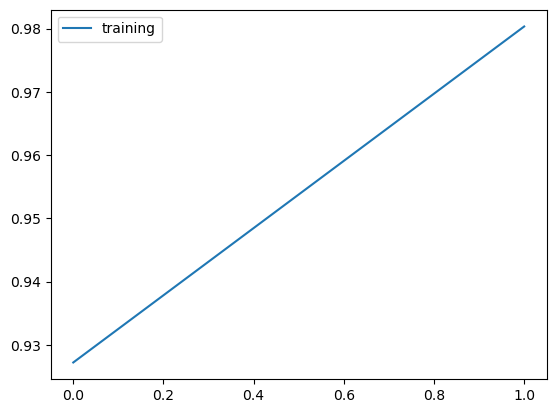

In [23]:
plt.plot(history.history["accuracy"], label="training")
# plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()
plt.show()

### What Accuracy Should You Aim For?

Your three different models might have noticeably different performance. Your best model should be able to consistently score at least 97% validation accuracy.

After comparing the performance of each model on validation data, make a recommendation regarding the question at the beginning of this section. Should algorithms use the title, the text, or both when seeking to detect fake news?

## Model Evaluation

Now we’ll test your model performance on unseen test data. For this part, you can focus on your best model, and ignore the other two.

Once you’re satisfied with your best model’s performance on validation data, download the test data here:

    test_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_test.csv?raw=true"

# Grading items:


#### Data Prep
1. Stopwords are removed during the construction of the data set.

2. make_dataset is implemented as a function, and used to create both the training/validation and testing data sets.

3. The constructed Dataset has multiple inputs.

4. Write a function to do train test split. 

5. 20% of the training data is split off for validation.

#### Models
6. Model 1 uses only the article title.

7. Model 2 uses only the article text.

8. Model 3 uses both the article title and text.

9. For model 3, embedding is consistent with the text vectorization method. i.e., if you use shared embedding layer, the preceding text vectorization layer also should be shared.

10. The training history is plotted for each of the three models, including the training and validation performance.

11. The most performant model is evaluated on the test data set.

12. The best model consistently obtains at least 97% accuracy on the validation set.

13. The best model’s performance on the test set is shown.

#### Style and Documentation

14. Throughout the HW, function docstrings, incline comments, and markdown are required. 